<a href="https://colab.research.google.com/github/ryghrmni/DeepLifeProject/blob/main/project04_cellsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Cell image segmentation projects**


---



**Team** (Alphabetical order)**:** Arvin Jafari, Delnavaz Fotouhi, Reza Ghahremani

**University:** Università degli Studi di Milano

** This course is provided by 4EU+ alliance of European universities, Heidelberg University will coordinate a joint course on Applications of Deep Learning in Life Sciences (DeepLife) involving the universities of Paris-Sorbonne, Warsaw, Prague, Milano and Heidelberg.

**Reference:** https://deeplife4eu.github.io/


---



Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide contains both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)

### Project aim

The aim of the project is to download the cell images (preferably from the “2018 Data Science Bowl” competition) and assess the performance of an UNet or any other Deep model for cell segmentation.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## **Step 1: Data Preparation**

**1.1. Install and Upgrade Kaggle Package**

The Kaggle Python package was installed and upgraded to ensure we have the latest version with all necessary functionalities.

In [1]:
!pip install --upgrade kaggle

**1.2. Verify and Create Kaggle Directory**

We verified if the ~/.kaggle directory exists. If not, the directory was created to store the Kaggle API credentials.

In [2]:
import os

# Verify ~/.kaggle directory exists
kaggle_dir = os.path.expanduser('~/.kaggle')
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
    print("Directory created: ~/.kaggle")
else:
    print("Directory already exists: ~/.kaggle")

Directory created: ~/.kaggle


**1.3. Copy Kaggle JSON to Kaggle Directory**

The kaggle.json file, which contains the API credentials, was copied to the ~/.kaggle directory. Permissions were set to ensure the file is secure.

In [3]:
import shutil

kaggle_json_path = 'kaggle.json'
target_path = os.path.join(kaggle_dir, 'kaggle.json')

if os.path.exists(kaggle_json_path):
    shutil.copy(kaggle_json_path, target_path)
    os.chmod(target_path, 0o600)
    print("kaggle.json has been copied to ~/.kaggle and permissions set.")
else:
    print("kaggle.json not found in the current directory.")

kaggle.json not found in the current directory.


**1.4. Set Environment Variables for Kaggle API**

Environment variables for the Kaggle username and key were set to enable authentication for API requests.

**reference:** https://www.kaggle.com/docs/api

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = input()
os.environ['KAGGLE_KEY'] = input()

arvinjmf
08908e6b7e12d90cd270e1aa2bfc58c9


**1.5. Download Dataset from Kaggle and Extract Dataset**

The dataset for the Data Science Bowl 2018 competition was downloaded using the Kaggle API. The downloaded zip file was extracted into a directory named data.

In [6]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:04<00:00, 79.0MB/s]
100% 358M/358M [00:05<00:00, 75.0MB/s]


In [7]:
!unzip data-science-bowl-2018.zip -d data

Archive:  data-science-bowl-2018.zip
  inflating: data/stage1_sample_submission.csv.zip  
  inflating: data/stage1_solution.csv.zip  
  inflating: data/stage1_test.zip    
  inflating: data/stage1_train.zip   
  inflating: data/stage1_train_labels.csv.zip  
  inflating: data/stage2_sample_submission_final.csv.zip  
  inflating: data/stage2_test_final.zip  


**1.6. Navigate to Data Directory and Extract All Files and List Directory Contents**

Changed the current working directory to data and extracted all zip files within it. The original zip files were then deleted. Finally, we listed the contents of the data directory to confirm the successful extraction of the dataset files.

In [8]:
cd data

/content/data


In [9]:
!for file in *.zip; do unzip -q "$file" -d "${file%%.*}" && rm "$file"; done

In [10]:
ls

stage1_sample_submission/  stage1_test/   stage1_train_labels/             stage2_test_final/
stage1_solution/           stage1_train/  stage2_sample_submission_final/


## **Step 2: Data Preprocessing and Augmenation**

**2.1. Stretch Contrast Function**

This function stretches the contrast of an image to utilize the full range of pixel values (0 to 255).

In [11]:
def stretch_contrast(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return stretched_image.astype(np.uint8)

**2.2. Load Data Function**

The load_data function is designed to load images and their corresponding masks from a given base directory, apply contrast stretching to the images, and organize the data into lists.

In [12]:
# def load_data(base_path):
#     images = []
#     masks = []
#     sample_names = []

#     sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

#     for sample_folder in sample_folders:
#         sample_name = os.path.basename(sample_folder)
#         image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
#         masks_path = os.path.join(sample_folder, 'masks')

#         image = Image.open(image_path)
#         image = np.array(image)
#         stretched_image = stretch_contrast(image)
#         images.append(stretched_image)
#         sample_names.append(sample_name)

#         mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
#         sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
#         masks.append(sample_masks)

#     return images, masks, sample_names

In [13]:
import os
import shutil
import random

# Define the source directory
source_dir = "/content/data/stage1_train"

# Define the destination directory
dest_dir = "/content/data/toy_data"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Get a list of all folders in the source directory
folders = os.listdir(source_dir)

# Randomly select 50 folders
selected_folders = random.sample(folders, 50)

# Copy selected folders to the destination directory
for folder in selected_folders:
    src = os.path.join(source_dir, folder)
    dst = os.path.join(dest_dir, folder)
    shutil.copytree(src, dst)

print("Selected folders have been copied to the 'toy_data' folder.")

Selected folders have been copied to the 'toy_data' folder.


In [14]:
def load_data(base_path):
    images = []
    masks = []
    sample_names = []
    sample_folders = []

    # Get all sample folders
    sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_folder in sample_folders:
        sample_name = os.path.basename(sample_folder)
        image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
        masks_path = os.path.join(sample_folder, 'masks')

        # Load the image and stretch contrast
        image = Image.open(image_path)
        image = np.array(image)
        stretched_image = stretch_contrast(image)
        images.append(stretched_image)
        sample_names.append(sample_name)

        # Load all masks for this sample
        mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
        sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
        masks.append(sample_masks)

    return images, masks, sample_names, sample_folders

In [15]:
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# # Example usage:
# base_path = '/content/data/toy_data'
# images, masks, sample_names = load_data(base_path)

# # Access the first sample
# first_sample_index = 0
# first_sample_name = sample_names[first_sample_index]
# first_sample_image = images[first_sample_index]
# first_sample_masks = masks[first_sample_index]

# # Print the sample name and display the image
# print(f'First sample name: {first_sample_name}')
# plt.figure()
# plt.imshow(first_sample_image)
# plt.title(f'Image: {first_sample_name}')
# plt.axis('off')
# plt.show()

# # Display the masks
# for i, mask in enumerate(first_sample_masks):
#     plt.figure()
#     plt.imshow(mask, cmap='gray')
#     plt.title(f'Mask {i + 1} for sample {first_sample_name}')
#     plt.axis('off')
#     plt.show()

# # Merge and display the masks
# merged_mask = merge_masks(first_sample_masks)

# plt.figure()
# plt.imshow(merged_mask, cmap='gray')
# plt.title(f'Merged Mask for sample {first_sample_name}')
# plt.axis('off')
# plt.show()

**2.3. Merge Masks Function**

This function merges multiple masks by adding the values of corresponding pixels.

In [16]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        mask_uint8 = mask.astype(np.uint8)
        merged_mask += mask_uint8
    return merged_mask

**2.4. Mask Merging**

The masks are merged to create a single composite mask for each sample, which is then saved for further analysis.

In [17]:
import numpy as np
from PIL import Image

In [18]:
# This function saves the merged mask as an image file in the 'merged_masks' folder within the sample folder.
def save_merged_mask(merged_mask, sample_folder):
    merged_masks_dir = os.path.join(sample_folder, 'merged_masks')
    os.makedirs(merged_masks_dir, exist_ok=True)
    sample_name = os.path.basename(sample_folder)
    output_path = os.path.join(merged_masks_dir, f"{sample_name}_merged_mask.png")
    merged_mask_image = Image.fromarray(merged_mask)
    merged_mask_image.save(output_path)
    print(f"Merged mask saved at: {output_path}")

In [19]:
# This function loads the data, merges the masks for each sample, and saves the merged masks in the corresponding folders.
def process_and_save_merged_masks(base_path):
    images, masks, sample_names, sample_folders = load_data(base_path)
    for sample_name, sample_masks, sample_folder in zip(sample_names, masks, sample_folders):
        merged_mask = merge_masks(sample_masks)
        save_merged_mask(merged_mask, sample_folder)

In [20]:
base_path = '/content/data/toy_data'
process_and_save_merged_masks(base_path)

Merged mask saved at: /content/data/toy_data/b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f/merged_masks/b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f_merged_mask.png
Merged mask saved at: /content/data/toy_data/9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001/merged_masks/9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001_merged_mask.png
Merged mask saved at: /content/data/toy_data/700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7/merged_masks/700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7_merged_mask.png
Merged mask saved at: /content/data/toy_data/66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f/merged_masks/66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f_merged_mask.png
Merged mask saved at: /content/data/toy_data/76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a/merged_masks/76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c4036

In [21]:
base_path = '/content/data/stage1_train'
process_and_save_merged_masks(base_path)

Merged mask saved at: /content/data/stage1_train/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72/merged_masks/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72_merged_mask.png
Merged mask saved at: /content/data/stage1_train/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e/merged_masks/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e_merged_mask.png
Merged mask saved at: /content/data/stage1_train/bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6/merged_masks/bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6_merged_mask.png
Merged mask saved at: /content/data/stage1_train/a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005/merged_masks/a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005_merged_mask.png
Merged mask saved at: /content/data/stage1_train/d256b32adda37f2301c9e46f34b7f9a36cce273256369ceb5dc2c73c3007e3c4/merged_masks/d256b32adda37f2301c9e46f34b7f9a36cce27325

## **3. Data Augmentation**

**2.5. Data Augmentation**

In [22]:
!pip install imgaug

In [23]:
import os
import numpy as np
from PIL import Image
import imgaug.augmenters as iaa

In [24]:
def augment_images_and_masks(images, masks, augmenters):
    """
    Apply augmentations to a list of images and masks in a synchronized manner.
    """
    deterministic_augmenters = augmenters.to_deterministic()
    aug_images = deterministic_augmenters(images=images)
    aug_masks = deterministic_augmenters(images=masks)
    return aug_images, aug_masks

In [25]:
def load_image(image_path):
    """
    Load an image from the specified path and return it as a numpy array.
    """
    image = Image.open(image_path)
    return np.array(image)

In [26]:
def save_image(image_array, output_path):
    """
    Save a numpy array as an image to the specified path.
    """
    image = Image.fromarray(image_array)
    image.save(output_path)

In [27]:
def create_augmented_folder(base_path, sample_name, num_augments=5):
    """
    Create augmented images for a given sample and save them in separate folders within the toy_data directory.
    """
    sample_folder = os.path.join(base_path, sample_name)
    images_path = os.path.join(sample_folder, 'images')
    masks_path = os.path.join(sample_folder, 'masks')

    # Load the image
    image_files = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.png')]
    image = load_image(image_files[0])
    images = [image]

    # Load masks
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.png')]
    masks = [load_image(mask_file) for mask_file in mask_files]

    # Merge masks
    merged_mask = merge_masks(masks)

    # Define augmentation pipeline
    augmenters = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Sometimes(1.0, iaa.Affine(rotate=[90, 180, 270])),
        iaa.Multiply((0.8, 1.2)),  # random brightness changes
        iaa.LinearContrast((0.75, 1.5)),  # random contrast changes
    ])

    # Generate and save augmented images and masks
    for i in range(num_augments):
        aug_images, aug_masks = augment_images_and_masks(images, [merged_mask], augmenters)

        # Create a subfolder for each augmented image and masks within the toy_data directory
        augmented_subfolder = os.path.join(base_path, f"{sample_name}_augmented_{i+1}")
        os.makedirs(augmented_subfolder, exist_ok=True)
        augmented_images_folder = os.path.join(augmented_subfolder, 'images')
        augmented_masks_folder = os.path.join(augmented_subfolder, 'merged_masks')
        os.makedirs(augmented_images_folder, exist_ok=True)
        os.makedirs(augmented_masks_folder, exist_ok=True)

        for j, aug_image in enumerate(aug_images):
            save_image(aug_image, os.path.join(augmented_images_folder, f"{sample_name}_aug_{i}_{j}.png"))
        for j, aug_mask in enumerate(aug_masks):
            save_image(aug_mask, os.path.join(augmented_masks_folder, f"{sample_name}_merged_mask_aug_{i}_{j}.png"))

    print(f"Augmented data saved in separate folders within stage1_train for sample: {sample_name}")

In [28]:
# Apply augmentation to all sample folders in the base path
def augment_all_samples(base_path, num_augments=5):
    """
    Apply augmentation to all sample folders within the base path.

    Args:
    - base_path (str): Path to the base directory containing images and masks.
    - num_augments (int): Number of augmented images to generate per sample.
    """
    sample_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_name in sample_folders:
        create_augmented_folder(base_path, sample_name, num_augments)

In [29]:
base_path = '/content/data/toy_data'
augment_all_samples(base_path, num_augments=2)

Augmented data saved in separate folders within stage1_train for sample: b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f
Augmented data saved in separate folders within stage1_train for sample: 9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001
Augmented data saved in separate folders within stage1_train for sample: 700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7
Augmented data saved in separate folders within stage1_train for sample: 66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f
Augmented data saved in separate folders within stage1_train for sample: 76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a
Augmented data saved in separate folders within stage1_train for sample: adc315bd40d699fd4e4effbcce81cd7162851007f485d754ad3b0472f73a86df
Augmented data saved in separate folders within stage1_train for sample: 8fdc34509a0c3721f7b5e235c8a93e1f553343aa17ad103a1e89e3509a3e1570
Augmented data saved in separate f

In [30]:
# base_path = '/content/data/stage1_train'
# augment_all_samples(base_path, num_augments=5)

**2.4. Data organization**

In [31]:
import os
import shutil
from PIL import Image

def extract_images(stage1_path, destination_path, content_type='images'):
    """
    Extract all images or merged masks from the stage1_train or stage1_test folder and save them into the specified destination folder.

    Args:
    - stage1_path (str): Path to the stage1_train or stage1_test folder containing sample folders.
    - destination_path (str): Path to the destination folder where images or masks will be saved.
    - content_type (str): Type of content to extract ('images' or 'merged_masks').
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Determine the subfolder to look for based on content type
    subfolder_name = 'images' if content_type == 'images' else 'merged_masks'

    # Iterate over all sample folders in the stage1 directory
    for sample_folder in os.listdir(stage1_path):
        sample_folder_path = os.path.join(stage1_path, sample_folder, subfolder_name)

        # Check if the sample folder contains the specified subfolder
        if os.path.isdir(sample_folder_path):
            for file in os.listdir(sample_folder_path):
                if file.endswith('.png'):
                    # Construct the full path to the file
                    file_path = os.path.join(sample_folder_path, file)

                    # Save the file to the destination directory
                    destination_file_path = os.path.join(destination_path, f"{sample_folder}_{file}")
                    shutil.copy(file_path, destination_file_path)
                    print(f"Copied: {file_path} to {destination_file_path}")

In [32]:
def main(destination_path):
    if 'train/images' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'images'
    elif 'train/masks' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'masks'
    elif 'test/images' in destination_path:
        stage1_path = '/content/data/stage1_test'
        content_type = 'images'
    else:
        print("Invalid destination path")
        return

    extract_images(stage1_path, destination_path, content_type)

In [33]:
destination_path = '/content/data/train/images'
main(destination_path)

destination_path = '/content/data/train/masks'
main(destination_path)

destination_path = '/content/data/test/images'
main(destination_path)

Copied: /content/data/stage1_train/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72/images/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72.png to /content/data/train/images/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72_1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72.png
Copied: /content/data/stage1_train/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e/images/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e.png to /content/data/train/images/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e_04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e.png
Copied: /content/data/stage1_train/bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6/images/bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6.png to /content/data/train/images/bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6_bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da

**Data Organization**



In [34]:
# def create_folders(base_path):
#     """
#     Create images_data and masks_data folders in the specified base path.

#     Args:
#     - base_path (str): Path to the base directory where the new folders will be created.
#     """
#     images_data_path = os.path.join(base_path, 'images_data')
#     masks_data_path = os.path.join(base_path, 'masks_data')

#     os.makedirs(images_data_path, exist_ok=True)
#     os.makedirs(masks_data_path, exist_ok=True)

#     print(f"Created folders: {images_data_path} and {masks_data_path}")
#     return images_data_path, masks_data_path

In [35]:
# def copy_images_and_masks(base_path, images_data_path, masks_data_path):
#     """
#     Copy all images from images folders and all masks from merged_masks folders
#     inside the toy_data folder to images_data and masks_data respectively.

#     Args:
#     - base_path (str): Path to the base directory containing the toy_data folder.
#     - images_data_path (str): Path to the images_data folder.
#     - masks_data_path (str): Path to the masks_data folder.
#     """
#     toy_data_path = os.path.join(base_path, 'toy_data')

#     # Traverse through all sample folders in toy_data
#     for sample_folder in os.listdir(toy_data_path):
#         sample_path = os.path.join(toy_data_path, sample_folder)

#         if os.path.isdir(sample_path):
#             # Copy images
#             images_folder = os.path.join(sample_path, 'images')
#             if os.path.exists(images_folder):
#                 for image_file in os.listdir(images_folder):
#                     if image_file.endswith('.png'):
#                         source_image_path = os.path.join(images_folder, image_file)
#                         target_image_path = os.path.join(images_data_path, f"{sample_folder}_{image_file}")
#                         shutil.copy(source_image_path, target_image_path)
#                         print(f"Copied image: {source_image_path} to {target_image_path}")

#             # Copy masks
#             masks_folder = os.path.join(sample_path, 'merged_masks')
#             if os.path.exists(masks_folder):
#                 for mask_file in os.listdir(masks_folder):
#                     if mask_file.endswith('.png'):
#                         source_mask_path = os.path.join(masks_folder, mask_file)
#                         target_mask_path = os.path.join(masks_data_path, f"{sample_folder}_{mask_file}")
#                         shutil.copy(source_mask_path, target_mask_path)
#                         print(f"Copied mask: {source_mask_path} to {target_mask_path}")

In [36]:
# base_path = '/content/data'
# images_data_path, masks_data_path = create_folders(base_path)
# copy_images_and_masks(base_path, images_data_path, masks_data_path)

In [39]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

  Using cached cellpose-3.0.8-py3-none-any.whl (204 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)


In [40]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Wed May 22 12:15:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              12W /  7

In [41]:
import os
from skimage import io
import numpy as np
from cellpose import models, utils, io as cp_io, train

# Paths to images and masks
train_dir = "/content/data/train"  # Path to the directory containing training images and masks
test_dir = None  # Set to None if you do not have a separate test directory

# Model name and path
initial_model = "cyto"  # Choose the appropriate pretrained model type
model_name = "CP_custom_model"  # Name of the new model

# Training parameters
n_epochs = 10  # Number of epochs

Channel_to_use_for_training = "Grayscale"  # Choose the primary channel

# If you have a secondary channel, specify it here; otherwise, set to "None"
Second_training_channel = "None"

# Advanced parameters
Use_Default_Advanced_Parameters = True  # Whether to use default advanced parameters
learning_rate = 0.1  # Default learning rate
weight_decay = 0.0001  # Default weight decay

if Use_Default_Advanced_Parameters:
    learning_rate = 0.1
    weight_decay = 0.0001

# Checking if a model with the same name already exists, and delete if so
model_path = os.path.join(train_dir, 'models')
if os.path.exists(os.path.join(model_path, model_name)):
    print(f"!! WARNING: {model_name} already exists and will be deleted !!")
    os.remove(os.path.join(model_path, model_name))

# Match the channel to number
chan = 0 if Channel_to_use_for_training == "Grayscale" else {"Red": 1, "Green": 2, "Blue": 3}.get(Channel_to_use_for_training, 0)
chan2 = 0 if Second_training_channel == "None" else {"Red": 1, "Green": 2, "Blue": 3}.get(Second_training_channel, 0)

if initial_model == 'scratch':
    initial_model = None

# Start logger to see training across epochs
logger = cp_io.logger_setup()

# Define Cellpose model (without size model)
model = models.CellposeModel(gpu=True, model_type=initial_model)

# Set channels
channels = [chan, chan2]

# Load images and masks
def load_images_and_masks(image_path, mask_path):
    images = []
    masks = []

    for filename in sorted(os.listdir(image_path)):
        if filename.endswith('.png'):
            image = io.imread(os.path.join(image_path, filename))
            images.append(image)

    for filename in sorted(os.listdir(mask_path)):
        if filename.endswith('.png'):
            mask = io.imread(os.path.join(mask_path, filename))
            masks.append(mask)

    return images, masks

image_path = os.path.join(train_dir, 'images')
mask_path = os.path.join(train_dir, 'masks')
train_data, train_labels = load_images_and_masks(image_path, mask_path)

# Perform sanity checks on the loaded data
print(f"Loaded {len(train_data)} training images")
print(f"Loaded {len(train_labels)} training masks")

if len(train_data) == 0 or len(train_labels) == 0:
    raise ValueError("No images or masks found. Please check the dataset directory structure and file names.")

# If you have a separate test set, load it; otherwise, set test_data and test_labels to None
if test_dir:
    test_image_path = os.path.join(test_dir, 'images')
    test_mask_path = os.path.join(test_dir, 'masks')
    test_data, test_labels = load_images_and_masks(test_image_path, test_mask_path)
else:
    test_data, test_labels = None, None

# Perform training
new_model_path = train.train_seg(
    model.net,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    channels=channels,
    save_path=train_dir,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    SGD=True,
    nimg_per_epoch=8,
    model_name=model_name,
    min_train_masks=1
)

# Diameter of labels in training images
diam_labels = model.net.diam_labels.item()

print("Model training completed and saved successfully!")


creating new log file


100%|██████████| 25.3M/25.3M [00:00<00:00, 67.5MB/s]


Loaded 670 training images
Loaded 670 training masks


 10%|▉         | 65/670 [00:17<02:44,  3.68it/s]


KeyboardInterrupt: 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio

# Define paths
model_path = '/content/data/train/models/CP_custom_model'
image_path = '/content/data/stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/images/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png'

# Load the trained model
model = models.CellposeModel(pretrained_model=model_path, gpu=True)

# Define channels to use
channels = [0, 0]  # Modify if you have specific channels to use


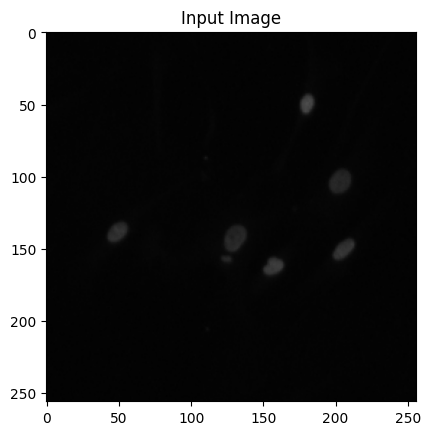

In [ ]:
# Load the image
image = skio.imread(image_path)

# Optionally, preprocess the image
# Example: stretch contrast if needed (uncomment if necessary)
# image = stretch_contrast(image)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.show()


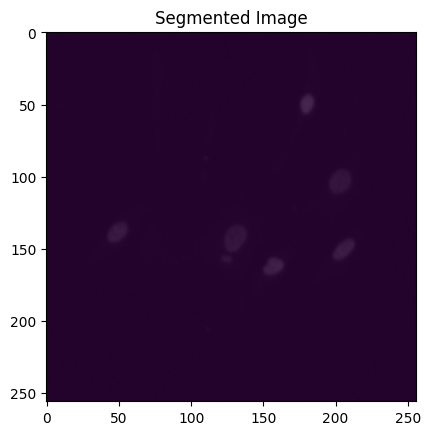

In [ ]:
# Run the model on the image
masks, flows, styles = model.eval(image, channels=channels, do_3D=False)

# 'masks' is the segmentation result
# Visualize the masks
plt.imshow(image, cmap='gray')
plt.imshow(masks, alpha=0.5)  # Overlay masks with some transparency
plt.title("Segmented Image")
plt.show()

